In [ ]:
import os               # for path joins
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import seaborn as sns
import cv2
from tqdm import tqdm

# basic seaborn style
sns.set_theme(style="ticks", font_scale=1.05)

In [41]:
# ---------------------------------------------------------------------------
# 1. CONFIGURATION
# ---------------------------------------------------------------------------

# project folder layout (adapt these two if your paths differ)
PROJECT_DIR = os.path.abspath('..')          # parent folder of the notebook
DATA_DIR    = os.path.join(PROJECT_DIR, 'data')

CSV_TRAIN = os.path.join(DATA_DIR, 'train.csv')
CSV_VAL   = os.path.join(DATA_DIR, 'val.csv')

# root folder that contains the raw images (data/raw/PlantVillage/…)
IMG_ROOT  = DATA_DIR

# sample sizes for heavy operations (you can change them)
SAMPLE_IMG_STATS   = 2_000   # how many images to measure size / channel stats
SAMPLE_GRID        =   12    # how many random images to display
SAMPLE_AUG_PREVIEW =    8    # how many images in the augmentation preview

In [42]:
# ---------------------------------------------------------------------------
# 2. LOAD THE CSV FILES
# ---------------------------------------------------------------------------

def load_csv(path):
    # Read a CSV and check it contains the expected columns.
    df = pd.read_csv(path)
    expected = {'filepath', 'species', 'disease'}
    if not expected.issubset(df.columns):
        raise ValueError(f"CSV {path} is missing one of {expected}")
    return df

train_df = load_csv(CSV_TRAIN)
val_df   = load_csv(CSV_VAL)

# add a column that tells us if the row is train or val
train_df['split'] = 'train'
val_df['split']   = 'val'

# put everything in one big DataFrame
full_df = pd.concat([train_df, val_df], ignore_index=True)

print('Train images:', len(train_df))
print('Val   images:', len(val_df))

Train images: 37571
Val   images: 9392


In [43]:
# ---------------------------------------------------------------------------
# 3. RESOLVE IMAGE PATHS TO ABSOLUTE PATHS
# ---------------------------------------------------------------------------
# We make sure that all paths are absolute

def make_abs_path(rel_path):
    # if the path is already absolute (starts with "/"), keep it
    if os.path.isabs(rel_path):
        return rel_path
    # if is relative we add PROJECT_DIR
    if rel_path.startswith('data'):
        return os.path.join(PROJECT_DIR, rel_path)
    # otherwise assume it is relative to IMG_ROOT
    return os.path.join(IMG_ROOT, rel_path)

full_df['abs_path'] = full_df['filepath'].apply(make_abs_path)

In [44]:
# ---------------------------------------------------------------------------
# 4. CHECK FOR MISSING OR CORRUPT FILES
# ---------------------------------------------------------------------------
# a) missing files – the file does not exist on disk
missing_mask = ~full_df['abs_path'].apply(os.path.exists)  # True if file is missing
missing_files = full_df[missing_mask]
print('Missing files referenced in CSV:', len(missing_files))

# b) corrupt files – OpenCV load check (sample max 1000)
check_paths = full_df['abs_path'].sample(n=min(1000, len(full_df)), random_state=0)
corrupt_paths = []

for p in check_paths:
    try:
        img = cv2.imread(p)
        if img is None:
            raise ValueError("Cannot read image")
    except Exception:
        corrupt_paths.append(p)

print('Corrupt images found in sample of 1000:', len(corrupt_paths))

Missing files referenced in CSV: 0
Corrupt images found in sample of 1000: 0


/var/folders/td/v7jn9s9n1rb36krxbncpn2mr0000gn/T/ipykernel_2590/808236695.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.values, y=counts.index,


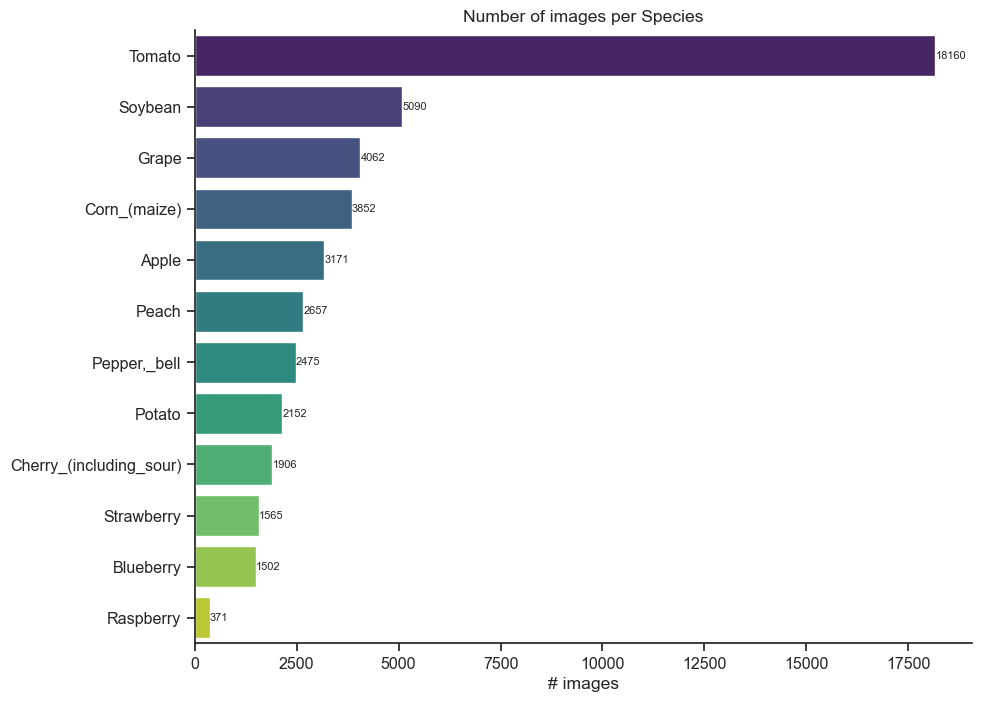

/var/folders/td/v7jn9s9n1rb36krxbncpn2mr0000gn/T/ipykernel_2590/808236695.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.values, y=counts.index,


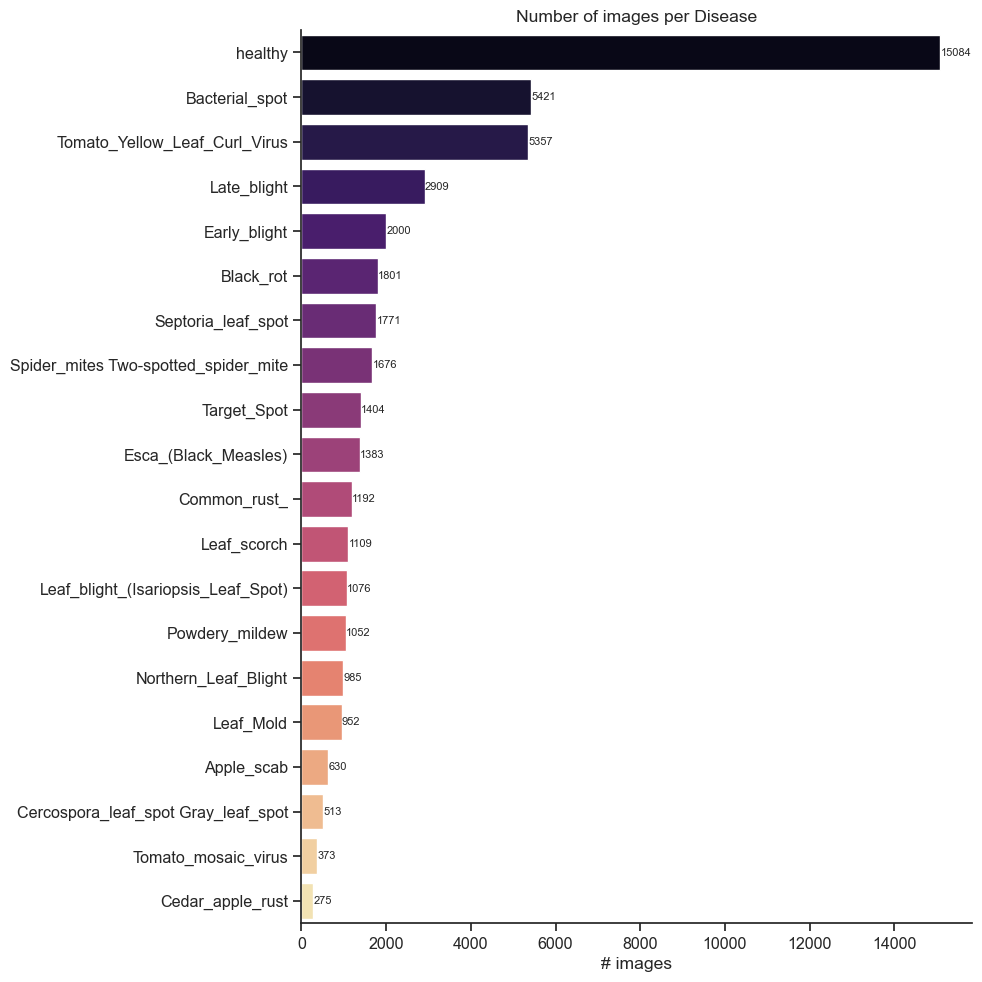

In [45]:
# ---------------------------------------------------------------------------
# 5. BAR CHARTS – HOW MANY IMAGES PER SPECIES / DISEASE
# ---------------------------------------------------------------------------
for label, column in [('Species', 'species'), ('Disease', 'disease')]:
    # count how many times each value appears
    counts = full_df[column].value_counts()

    # figure height grows with the number of categories (for readability)
    bar_height = 0.35 * len(counts) + 3   # simple formula that worked well
    plt.figure(figsize=(10, bar_height))

    sns.barplot(x=counts.values, y=counts.index,
                palette='viridis' if label == 'Species' else 'magma')

    plt.title(f'Number of images per {label}')
    plt.xlabel('# images')
    plt.ylabel('')

    # write the count number to the right of each bar
    for value, y in zip(counts.values, range(len(counts))):
        plt.text(value + 5, y, str(value), va='center', fontsize=8)

    sns.despine()
    plt.tight_layout()
    plt.show()

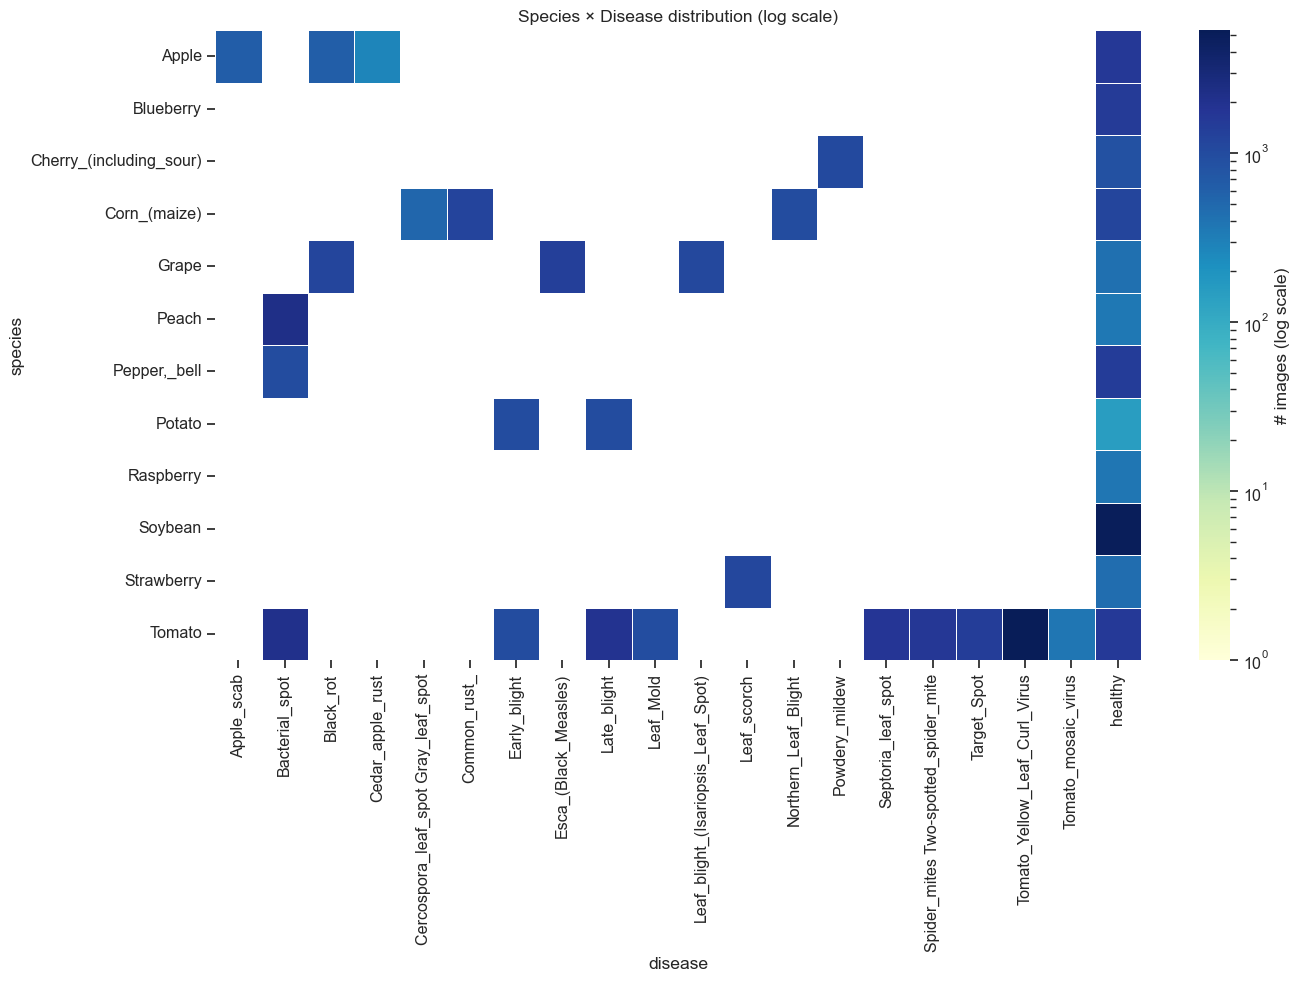

In [46]:
# ---------------------------------------------------------------------------
# 6. HEATMAP – SPECIES × DISEASE, LOG‑SCALE COLOR BAR
# ---------------------------------------------------------------------------
# create a pivot table where each cell = number of images for that combination
heat = (
    full_df
      .assign(count=1)                       # adds a column filled with 1
      .pivot_table(index='species',          # rows   → species
                   columns='disease',       # columns→ disease
                   values='count',
                   aggfunc='sum',
                   fill_value=0)            # 0 means that combo is absent
)

# height of figure based on number of species
fig_height = 0.5 * heat.shape[0] + 4
plt.figure(figsize=(14, fig_height))

sns.heatmap(
    heat,
    cmap='YlGnBu',
    norm=LogNorm(vmin=max(1, heat.values.min()), vmax=heat.values.max()),  # log colour scale
    cbar_kws={'label': '# images (log scale)'},
    linewidths=.4
)
plt.title('Species × Disease distribution (log scale)')
plt.tight_layout(); plt.show()

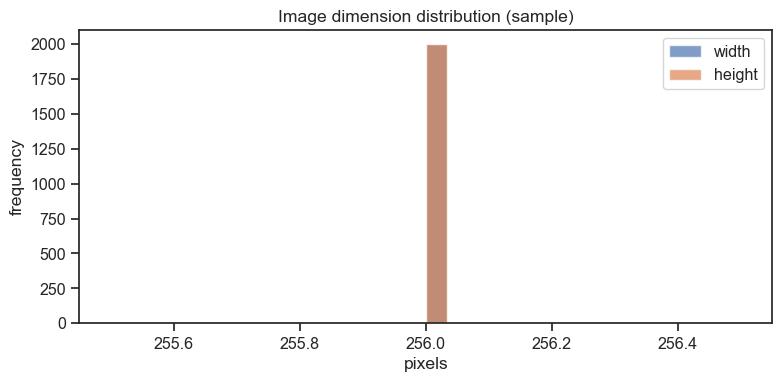

Median size: 256 × 256
Mean   size: 256 × 256


In [47]:
# ---------------------------------------------------------------------------
# 7. IMAGE SIZE DISTRIBUTION (WIDTH AND HEIGHT HISTOGRAMS)
# ---------------------------------------------------------------------------
if SAMPLE_IMG_STATS > 0:
    size_sample = full_df['abs_path'].sample(n=min(SAMPLE_IMG_STATS, len(full_df)), random_state=1)
    all_sizes = []

    for p in size_sample:
        img = cv2.imread(p)
        if img is not None:
            h, w = img.shape[:2]
            all_sizes.append((w, h))

    widths  = [w for (w, h) in all_sizes]
    heights = [h for (w, h) in all_sizes]

    plt.figure(figsize=(8, 4))
    plt.hist(widths,  bins=30, alpha=0.7, label='width')
    plt.hist(heights, bins=30, alpha=0.7, label='height')
    plt.xlabel('pixels'); plt.ylabel('frequency'); plt.legend()
    plt.title('Image dimension distribution (sample)')
    plt.tight_layout(); plt.show()

    print('Median size:', int(np.median(widths)), '×', int(np.median(heights)))
    print('Mean   size:', int(np.mean(widths)),   '×', int(np.mean(heights)))

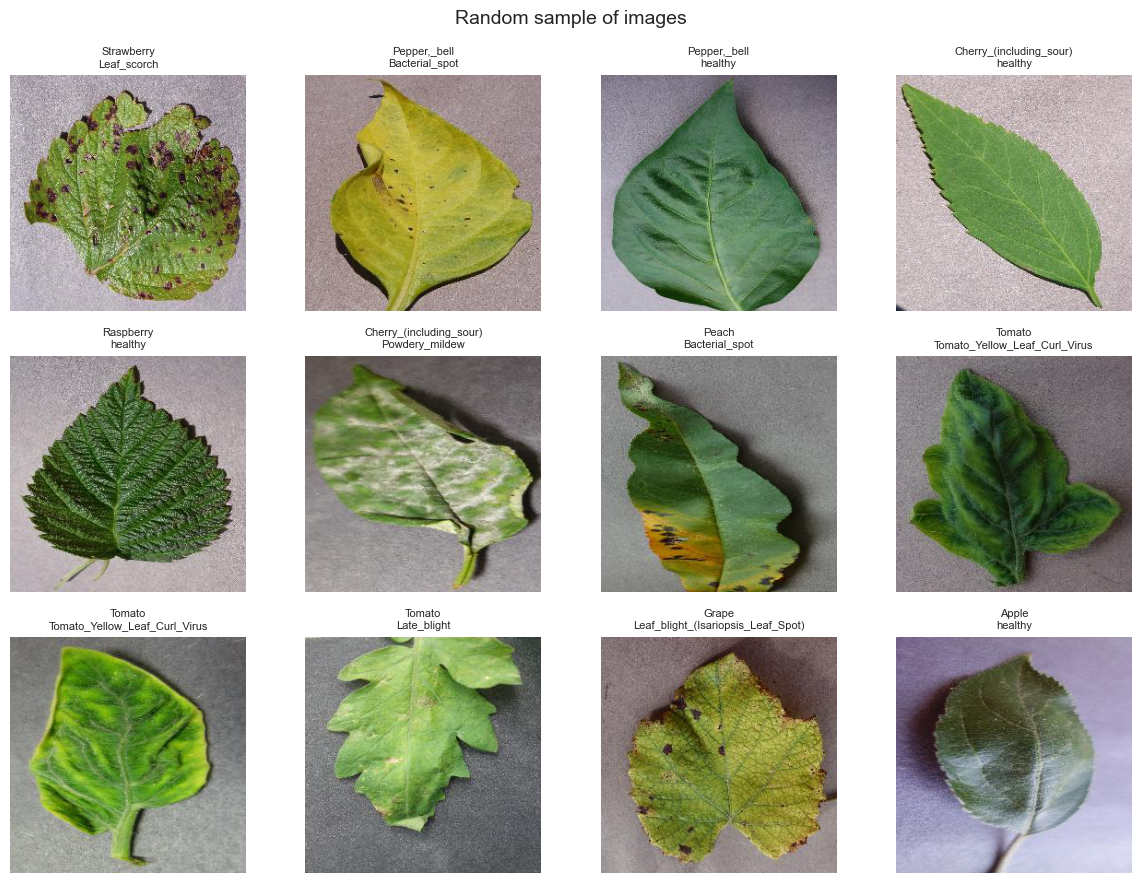

In [48]:
# ---------------------------------------------------------------------------
# 8. RANDOM GRID OF SAMPLE IMAGES (HANDLES MISSING / CORRUPT)
# ---------------------------------------------------------------------------
GRID = SAMPLE_GRID
sample_df = full_df.sample(GRID, random_state=2)
cols = 4
rows = (GRID + cols - 1) // cols  # ceiling division
fig, axes = plt.subplots(rows, cols, figsize=(12, 3*rows))
axes = axes.flatten()

for ax, (_, row) in zip(axes, sample_df.iterrows()):
    path = row['abs_path']
    if not os.path.exists(path):
        ax.set_title('missing', fontsize=8)
        ax.axis('off')
        continue
    try:
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    except Exception:
        ax.set_title('corrupt', fontsize=8)
        ax.axis('off')
        continue

    ax.imshow(img)
    ax.set_title(f"{row['species']}\n{row['disease']}", fontsize=8)
    ax.axis('off')

# hide extra axes if GRID is not a multiple of cols
for ax in axes[GRID:]:
    ax.axis('off')

plt.suptitle('Random sample of images', fontsize=14)
plt.tight_layout(); plt.show()

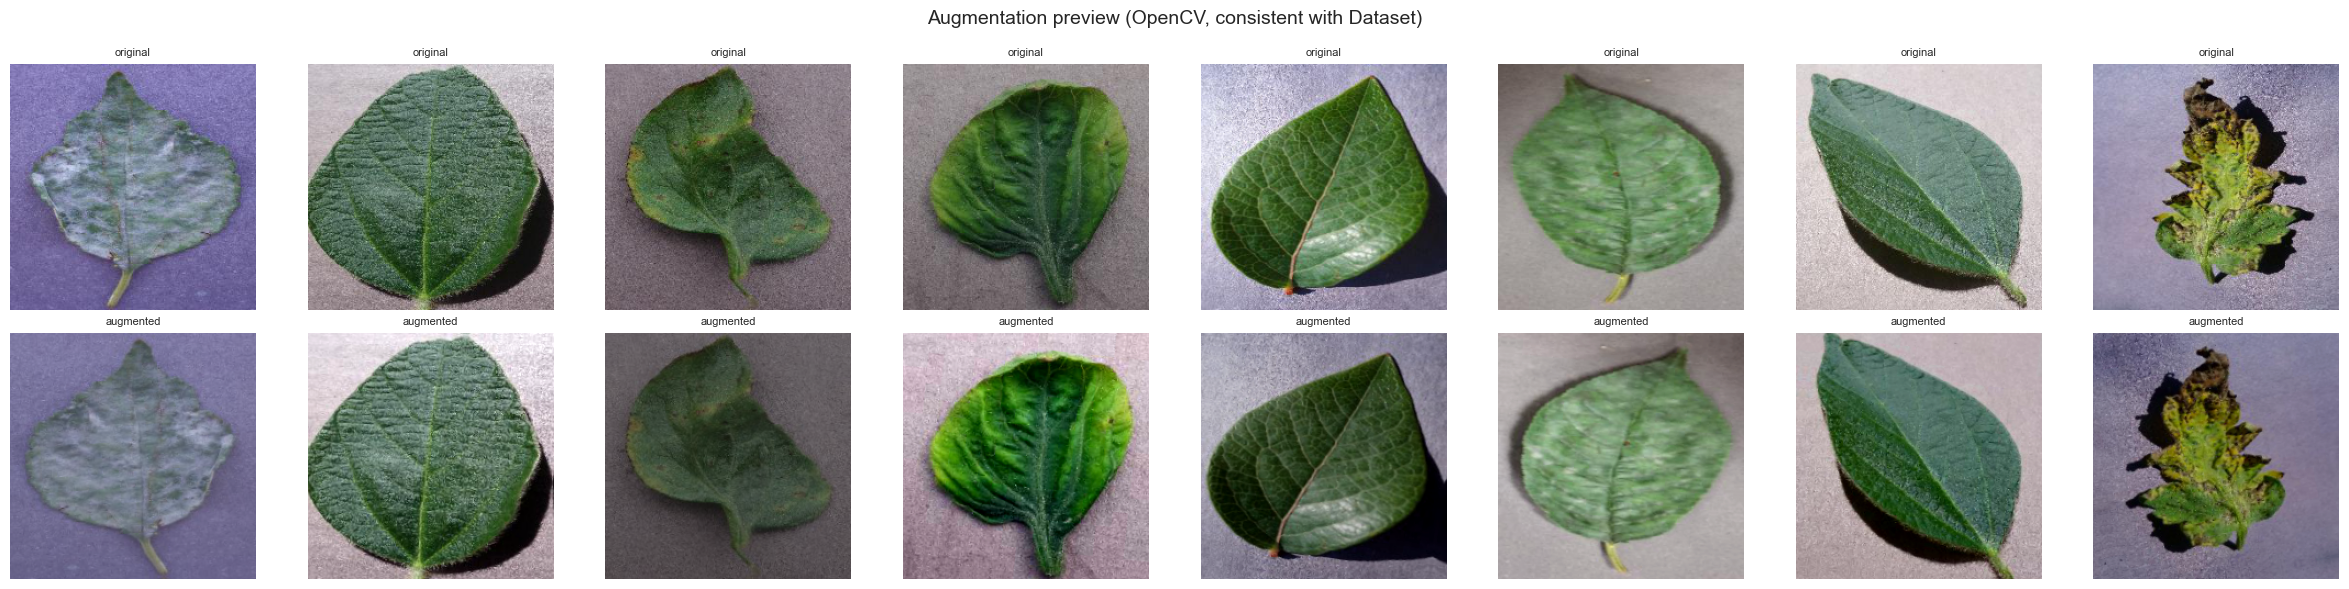

In [65]:
# ---------------------------------------------------------------------------
# 9. SIMPLE AUGMENTATION PREVIEW (OpenCV – consistent with LeafDatasetCV)
# ---------------------------------------------------------------------------

# Mean and std from your dataset (R, G, B)
dataset_mean = np.array([0.47131167, 0.49435022, 0.42405355])
dataset_std  = np.array([0.17719288, 0.14827244, 0.19360321])

def augment_image_cv2(img):
    """
    Apply the same augmentations used in LeafDatasetCV
    """
    # Horizontal flip with 50% chance
    if np.random.rand() < 0.5:
        img = cv2.flip(img, 1)

    # Random rotation between -15 and 15 degrees
    angle = np.random.uniform(-15, 15)
    h, w = img.shape[:2]
    M = cv2.getRotationMatrix2D((w // 2, h // 2), angle, 1.0)
    img = cv2.warpAffine(img, M, (w, h), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT_101)
    
    # Convert to HSV for saturation jitter
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

    # Brightness jitter (value channel)
    brightness_factor = np.random.uniform(0.7, 1.3)
    hsv[..., 2] = np.clip(hsv[..., 2].astype(np.float32) * brightness_factor, 0, 255).astype(np.uint8)

    # Saturation jitter
    saturation_factor = np.random.uniform(0.7, 1.3)
    hsv[..., 1] = np.clip(hsv[..., 1].astype(np.float32) * saturation_factor, 0, 255).astype(np.uint8)

    # Back to RGB
    img = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

    # Contrast jitter (on RGB)
    contrast_factor = np.random.uniform(0.7, 1.3)
    mean = img.mean(axis=(0, 1), keepdims=True)
    img = np.clip((img.astype(np.float32) - mean) * contrast_factor + mean, 0, 255).astype(np.uint8)

    return img

# Sample images to preview
prev_paths = full_df['abs_path'].sample(SAMPLE_AUG_PREVIEW, random_state=3)
fig, axes = plt.subplots(2, SAMPLE_AUG_PREVIEW, figsize=(3 * SAMPLE_AUG_PREVIEW, 6))

for i, path in enumerate(prev_paths):
    try:
        orig = cv2.imread(path)
        orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB)
        orig = cv2.resize(orig, (224, 224))
        orig_norm = (orig.astype(np.float32) / 255.0 - dataset_mean) / dataset_std

        # Apply augmentation
        aug = augment_image_cv2(orig.copy())
        aug_norm = (aug.astype(np.float32) / 255.0 - dataset_mean) / dataset_std

        # Display: convert back to [0, 1] RGB for matplotlib
        axes[0, i].imshow(np.clip((orig_norm * dataset_std + dataset_mean), 0, 1))
        axes[0, i].set_title('original', fontsize=8)
        axes[0, i].axis('off')

        axes[1, i].imshow(np.clip((aug_norm * dataset_std + dataset_mean), 0, 1))
        axes[1, i].set_title('augmented', fontsize=8)
        axes[1, i].axis('off')

    except Exception as e:
        axes[0, i].set_title('error')
        axes[0, i].axis('off')
        axes[1, i].axis('off')

plt.suptitle('Augmentation preview (OpenCV, consistent with Dataset)', fontsize=14)
plt.tight_layout()
plt.show()

In [50]:
# ---------------------------------------------------------------------------
# 10. SAVE A SUMMARY CSV (IMAGES PER CLASS PER SPLIT)
# ---------------------------------------------------------------------------
summary = full_df.groupby(['species', 'disease', 'split']).size().unstack(fill_value=0)
summary_path = os.path.join(DATA_DIR, 'class_counts_summary.csv')
summary.to_csv(summary_path)
print('✔ Summary CSV saved to', summary_path)

print('EDA finished ✔')

✔ Summary CSV saved to /Users/zenotesta/Documents/GitHub/LeafAI/data/class_counts_summary.csv
EDA finished ✔


In [55]:
# ---------------------------------------------------------------------------
# 11. CALCULATE MEAN AND STD (for normalization)
# ---------------------------------------------------------------------------

print("Calculating mean and std from sample images...")
sample_paths = full_df['abs_path'].sample(n=min(SAMPLE_IMG_STATS, len(full_df)), random_state=42)

mean_sum = np.zeros(3)
std_sum = np.zeros(3)
count = 0

for path in tqdm(sample_paths):
    img = cv2.imread(path)
    if img is not None:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (224, 224))
        img = img.astype(np.float32) / 255.0

        mean_sum += img.mean(axis=(0, 1))
        std_sum += img.std(axis=(0, 1))
        count += 1

dataset_mean = mean_sum / count
dataset_std = std_sum / count

print("Dataset mean:", dataset_mean)
print("Dataset std: ", dataset_std)

Calculating mean and std from sample images...


100%|██████████| 2000/2000 [00:03<00:00, 508.96it/s]

Dataset mean: [0.46986786 0.49171314 0.42178439]
Dataset std:  [0.17823954 0.14965313 0.19491802]
